# CODE SUPPORT

### Imports and settings

In [1737]:
# Data extraction
from ucimlrepo import fetch_ucirepo

# Data handling
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import pickle

# Data viz
import warnings
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# ML packages
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
shap.initjs()

In [1738]:
warnings.filterwarnings('ignore')

### Helper Functions

In [1739]:
def uci_heart_data():
    '''
    Downloads dataset from the UCI Repository: Heart Disease.

    Parameters:
        None.
    
    Returns:
        DataFrame: heart disease dataset.
    '''
    heart_disease = fetch_ucirepo(name='Heart Disease')

    df_features = heart_disease.data.features
    df_target = heart_disease.data.targets
    df_full = pd.concat([df_features, df_target], axis=1)
    
    return df_full


def recall_f1_cv(x_cv, y_cv, model_name, model, kfold=5, verbose=False):
    '''
    Cross-Validation for classifier models.

    This CV helper function is made for non-ordinal classifier models,
    thinking about the redution of False Negatives in our results.
    Scores: Recall and F1.

    Parameters: 
        'x_cv': X_train, 
        'y_cv': y_train, 
        'model_name': user name to the model that's gonna be used, 
        'model': ML model that's gonna be used, 
        'kfold': number of splits in the cross-validation (default=5), 
        'verbose': some information when running the function (default=False).
    
    Returns:
        'model_name',
        average sklean.recall_score for the cross-validation,
        average sklean.f1_score for the cross-validation.
    '''
    recall_list = []
    f1_list = []

    # We are going to use an index reset to apply our kfold limits.
    df_aux = pd.concat([x_cv, y_cv], axis=1)
    df_aux.reset_index(inplace=True, drop=True)
    df_cv = df_aux.reset_index()

    index_max = df_cv['index'].max()

    for k in range( 1, (kfold + 1) ):
        # This divides the data in kfold parts.
        if verbose:
            # For verbose=True, shows the KFold input.
            print( '\nKFold Number: {} / {}'.format(k, kfold) )
        
        # Parameter to include last index in the split.
        z = 0
        if k == kfold:
            z = 1
            
        # Splitting train-validation.
        df_train = df_cv[
            (df_cv['index'] < (index_max * (k-1) / kfold)) | 
            (df_cv['index'] >= (index_max * (k+z) / kfold))]
        if verbose:
            print(df_train.shape)
        
        df_val = df_cv[
            (df_cv['index'] >= (index_max * (k-1) / kfold)) & 
            (df_cv['index'] < (index_max * (k+z) / kfold))]
        if verbose:
            print(df_val.shape)

        # Training dataset.
        x_train = df_train.drop(['index', 'num'], axis=1)
        y_train = df_train['num']

        # Validation dataset.
        x_val = df_val.drop(['index', 'num'], axis=1)
        y_val = df_val['num']

        # Model training.
        m = model.fit( x_train, y_train )

        # Prediction.
        y_pred = m.predict(x_val)

        # Storing Recall and F1 scores.
        recall_list.append(recall_score(y_val, y_pred))
        f1_list.append(f1_score(y_val, y_pred))

    # Performance results
    return pd.DataFrame({'Model Name': model_name,
                        'Recall Score': np.round(np.mean(recall_list), 2).astype( str ),
                        'F1 Score': np.round(np.mean(f1_list), 2).astype( str )},
                        index=[0])

# 0 BUSINESS UNDERSTANDING

### CRISP for Data Science

This is the methodology I use in my projects.

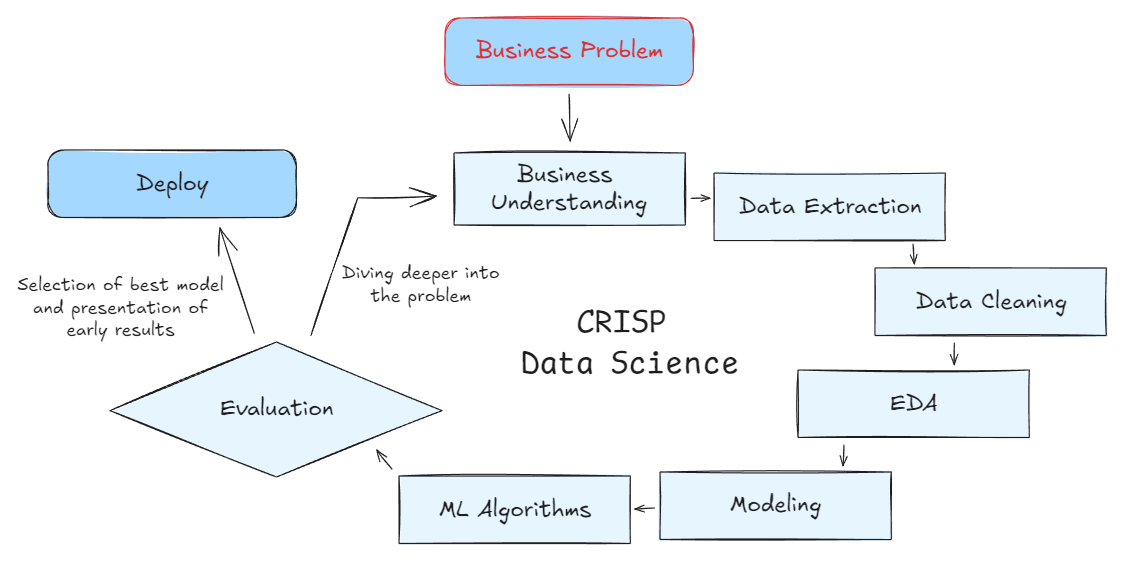

In [1740]:
# Loading crisp img
img = Image.open('img/crisp.png')

# Show
display(img)

### Understanding the Problem

Then we begin tackling the problem by understanding it.

Objective of this study:
    - Supporting the development of a heart disease prevention system!

My job as a Data Scientist is to create a predictive model to identify patients more likely to develop heart diseases.


Dataset available in the URL from UC Irvine (UCI) ML Repository: https://archive.ics.uci.edu/ml/datasets/heart+disease.
It's made of 4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach.

### Understanding the Data

As I don't have support from a medical team, my decisions are solely made out of my dataset limited interpretation.

Below, we can see a table with the variables information summary, taken directly from the UCI ML Repository.

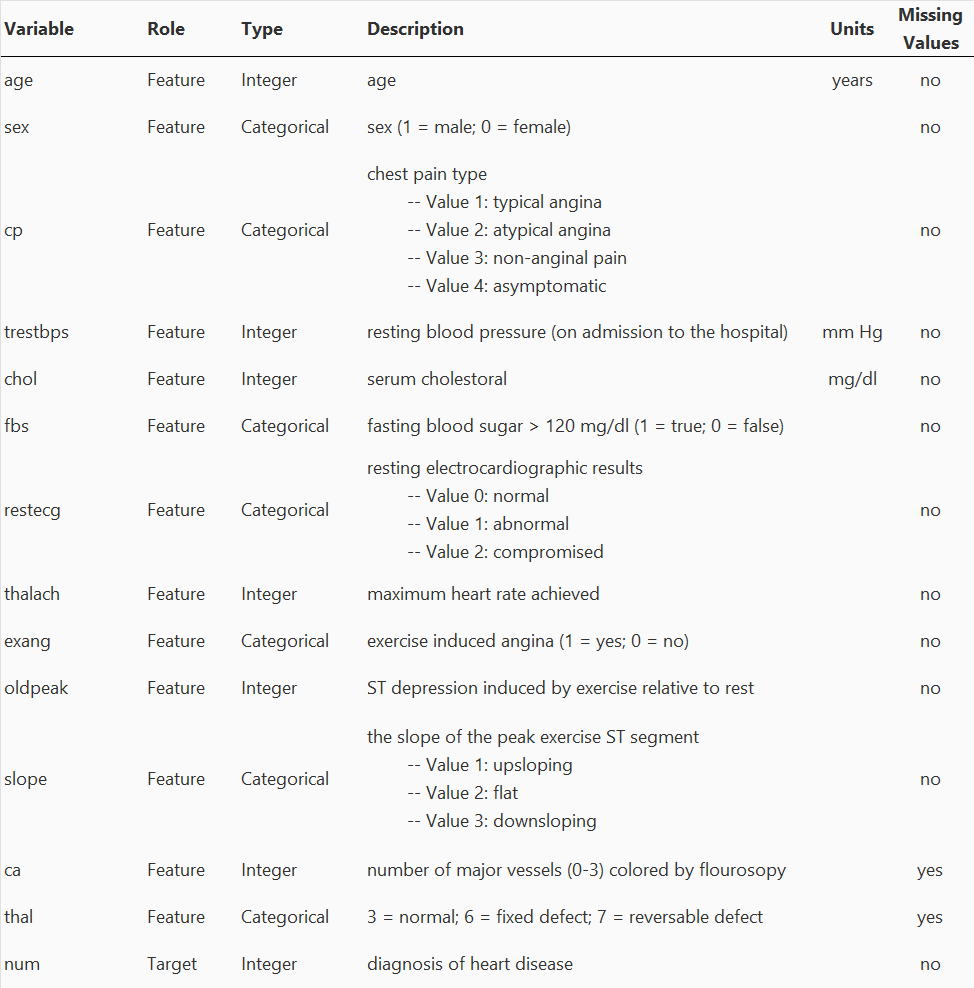

In [1741]:
# Loading data_features img
img = Image.open('img/dataset_variables.png')

# Show
display(img)

The Target feature also have this extra info:

num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels)

Because we have the Target feature, it's possible to use supervised models to predict whether or not new patients are prone to heart diseases.

The next steps are Data Extraction and Data Cleaning. We can better understand the data he have by diving into it.

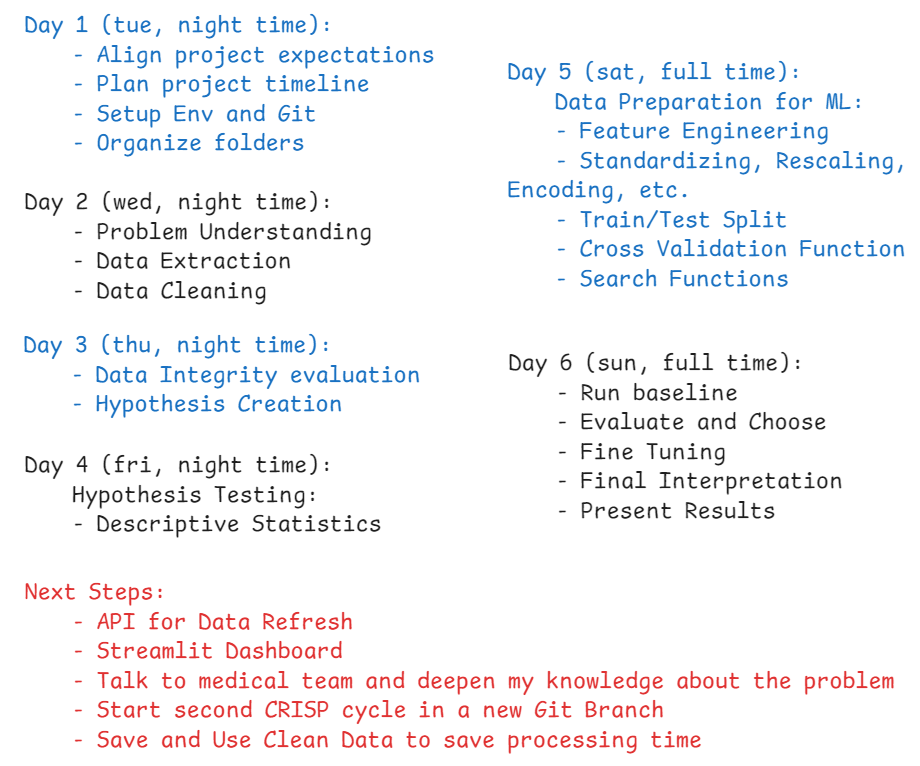

In [1742]:
# Loading timeline img
img = Image.open('img/timeline.png')

# Show
display(img)

# 1 DATA EXTRACTION

In [1743]:
# Downloading the dataset from UCI.
df1 = uci_heart_data()

# 2 DATA CLEANING

In [1744]:
# Now we begin to understand how the dataset was built in more depth.
df2 = df1.copy()

### 2.1 Data Description

In [1745]:
# Just taking a look at the dataframe.
df2.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1


In [1746]:
# First let's get rid of duplications, if they exist.
df2.drop_duplicates()

# Checking dataframe size.
print( 'Rows: {}'.format( df2.shape[0] ) )
print( 'Cols: {}'.format( df2.shape[1] ) )

Rows: 303
Cols: 14


In [1747]:
# Displaying information about variables types and missing values.
type_value_analysis = pd.concat(
    [df2.dtypes, df2.isna().sum()], 
    axis=1, 
    keys=['Data Types', 'Missing Values'])
print(type_value_analysis)

         Data Types  Missing Values
age           int64               0
sex           int64               0
cp            int64               0
trestbps      int64               0
chol          int64               0
fbs           int64               0
restecg       int64               0
thalach       int64               0
exang         int64               0
oldpeak     float64               0
slope         int64               0
ca          float64               4
thal        float64               2
num           int64               0


### 2.2 Missing Values

In [1748]:
# Trying to understand the missing values.
df2[(df2['ca'].isna()) | (df2['thal'].isna())]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN,2
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0


In [1749]:
# I don't have any other information that could help determine the missing values 
# for 'ca' (flouroscopy result) or 'thal' (whatever this is). 
# 
# The decision here is to drop them. It's just 2.3% of our dataset, we'll survive.
df2 = df2.dropna()

### 2.3 Data Types

In [1750]:
# We have to take a look in the variables with data type float64, as the 
# int64 alreary have their values determined by the nature of its type.
# 
# These are 'oldpeak', 'ca' and 'thal'. Let's check their values. 
# 
# P.S.: UCI Repository says that 'oldpeak' and 'ca' are integer and 'thal' 
# is categorical.
unique_values_dict = {
    'oldpeak': list(df2['oldpeak'].unique()),
    'ca': list(df2['ca'].unique()),
    'thal': list(df2['thal'].unique())
}

for i in unique_values_dict:
    print('{}: {}'.format(i, unique_values_dict[i]))

oldpeak: [2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 3.1, 0.4, 1.3, 0.0, 0.5, 1.6, 1.0, 1.2, 0.2, 1.8, 3.2, 2.4, 2.0, 2.5, 2.2, 2.8, 3.0, 3.4, 6.2, 4.0, 5.6, 2.9, 0.1, 2.1, 1.9, 4.2, 0.9, 1.1, 3.8, 0.7, 0.3, 4.4]
ca: [0.0, 3.0, 2.0, 1.0]
thal: [6.0, 3.0, 7.0]


In [1751]:
# As we can see, 'ca' and 'thal' can be stored as integer. But, contrary to 
# the UCI recommendation, 'oldpeak' is indeed float.
variables_to_integer = ['ca', 'thal']

for i in variables_to_integer:
    df2[i] = df2[i].astype('int64')

### 2.4 Identifying Categorical and Numerical Data

In [1752]:
# Let's display unique values for each variable. Then we can decide on
# the nature of the data attributes.
attributes = list(df2.columns)
attributes_dict = {}

for att in attributes:
    attributes_dict[att] = list(df2[att].unique())

for i, j in attributes_dict.items():
    print('{}: {}'.format(i, j))

age: [63, 67, 37, 41, 56, 62, 57, 53, 44, 52, 48, 54, 49, 64, 58, 60, 50, 66, 43, 40, 69, 59, 42, 55, 61, 65, 71, 51, 46, 45, 39, 68, 47, 34, 35, 29, 70, 77, 38, 74, 76]
sex: [1, 0]
cp: [1, 4, 3, 2]
trestbps: [145, 160, 120, 130, 140, 172, 150, 110, 132, 117, 135, 112, 105, 124, 125, 142, 128, 170, 155, 104, 180, 138, 108, 134, 122, 115, 118, 100, 200, 94, 165, 102, 152, 101, 126, 174, 148, 178, 158, 192, 129, 144, 123, 136, 146, 106, 156, 154, 114, 164]
chol: [233, 286, 229, 250, 204, 236, 268, 354, 254, 203, 192, 294, 256, 263, 199, 168, 239, 275, 266, 211, 283, 284, 224, 206, 219, 340, 226, 247, 167, 230, 335, 234, 177, 276, 353, 243, 225, 302, 212, 330, 175, 417, 197, 198, 290, 253, 172, 273, 213, 305, 216, 304, 188, 282, 185, 232, 326, 231, 269, 267, 248, 360, 258, 308, 245, 270, 208, 264, 321, 274, 325, 235, 257, 164, 141, 252, 255, 201, 222, 260, 182, 303, 265, 309, 307, 249, 186, 341, 183, 407, 217, 288, 220, 209, 227, 261, 174, 281, 221, 205, 240, 289, 318, 298, 564, 246, 322,

In [1753]:
# The values for 'num' are not as expected from the data description from UCI.
# As we should have only 0 or 1, for False and True.

In [1754]:
# Complete list of attributes:
attributes = list(df2.columns)

# For the numerical attributes, we can identify:
num_attributes = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# And for the categorical ones, we have:
cat_attributes = [att for att in attributes if att not in num_attributes]

### 2.5 Adjusting Values

In [1755]:
# As we saw, 'num' values are not as expected. We can follow 
# with 0 as 0, but 1, 2, 3, 4 as 1. 
# If I'd take a guess, it may identify from which of the four
# databases these positives come from.
df2.loc[df2['num'] > 0, 'num'] = 1

### 2.6 Removing Outliers

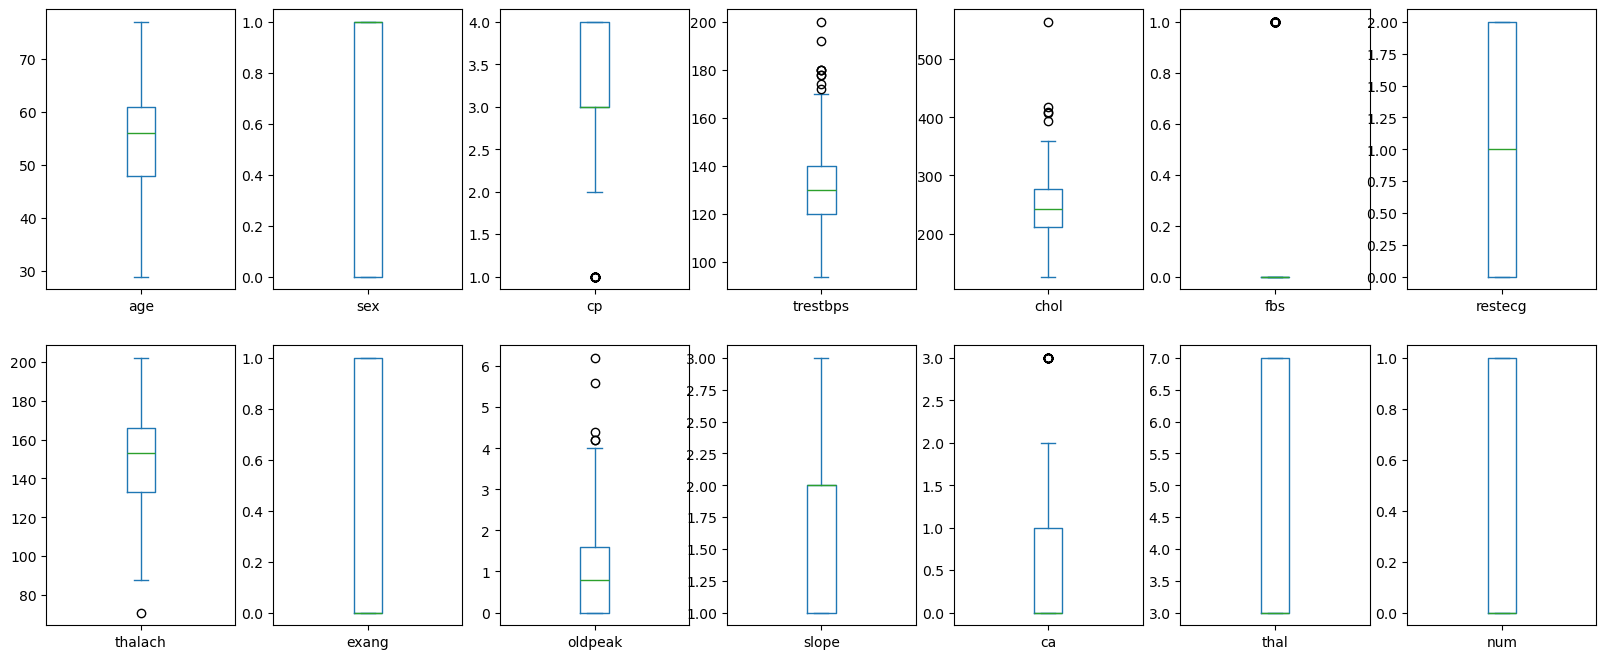

In [1756]:
# Plotting boxplot to spot outliers.
df2.plot(kind='box', subplots=True, layout=(2, 7), figsize=(20,8));

In [1757]:
# We can observe that 'trestbps', 'chol' and 'odpeak' show
# outliers. We can make a for loop to get rid of those cases.
df2_filtered = df2.copy()

for att in num_attributes:
    # Getting Q1 and Q3.
    q1 = np.percentile(df2_filtered[att], 25)
    q3 = np.percentile(df2_filtered[att], 75)

    # Then the Interquartile Range (IQR).
    iqr = q3 - q1

    # And determine Inferior and Superior Limits.
    # Everything out of these boundaries are gonna be treated
    # as outliers.
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df2_filtered = df2_filtered[(df2_filtered[att] >= lower_bound) & 
                                (df2_filtered[att] <= upper_bound)]
    
print(f'Original df2 shape: {df2.shape}')
print(f'Filtered df2 shape: {df2_filtered.shape}')


Original df2 shape: (297, 14)
Filtered df2 shape: (278, 14)


In [1758]:
# With outliers removed in our df2_filtered, let's
# copy it to our df2.
df2 = df2_filtered.copy()

# 3 EXPLORATORY DATA ANALYSIS

In [1759]:
# It's adventure time.
df3 = df2.copy()

### 3.1 Hypothesis Creation 

In [1760]:
# NUMERICAL ATTRIBUTES
# 1. age - Risk patients tend to be older;

# 2. trestbps - Risk patients are more common to have higher resting
# blood pressure;

# 3. chol - It's more common to find high serum cholesterol patients
# among the risk group;

# 4. thalach - maximum heart rate achieved higher for risk patients,
# athletes tend to have lower heart rate overall;

# 5. oldpeak - ST segment instability are common in patients with heart
# disease.


# CATEGORICAL ATTRIBUTES
# 6. sex - Women (0) take more care of themselves and see doctors more 
# often, meaning lower risk of developing diseases in general;

# 7. cp - chest pain (1, 2, 3) may indicate problems around the chest, 
# anginal (1, 2) often indicate a heart disease (value 4 should be more 
# common in healthy patients);

# 8. fbs - high sugar (1) is usually related to heart diseases;

# 9. restecg - abnormal (1) and compromised (2) ECG results should be
# more often on risk patients;

# 10. exang - angina by exercising (1) should indicate risk;

# 11. slope - ST slope should be flat (2), most important cause of
# ST segment abnormality is myocardial ischaemia or infarction 
# (source: litfl.com/st-segment-ecg-library/ accessed in 2024-sep-07);

# 12. ca - I don't know what result we should get, let's assume
# that lower vessels mean higher risk;

# 13. thal - normal (3) means lower risk, defects (6, 7) should be 
# more common in risk patients.


### 3.2 Descriptive Analysis for each Variable

#### 3.2.1 Numerical Attributes

##### <font color='lightblue'> Univariate Analysis </font>

In [1761]:
# Central Tendency
ct1 = pd.DataFrame( df3[num_attributes].apply( np.mean ) ).T
ct2 = pd.DataFrame( df3[num_attributes].apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( df3[num_attributes].apply( np.std ) ).T
d2 = pd.DataFrame( df3[num_attributes].apply( min ) ).T
d3 = pd.DataFrame( df3[num_attributes].apply( max ) ).T
d4 = pd.DataFrame( df3[num_attributes].apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df3[num_attributes].apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df3[num_attributes].apply( lambda x: x.kurtosis() ) ).T

summary = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
summary.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,29.0,77.0,48.0,54.172662,55.0,9.120242,-0.160403,-0.554301
1,trestbps,94.0,170.0,76.0,129.949640,130.0,15.570135,0.260905,-0.267346
2,chol,126.0,360.0,234.0,243.147482,240.0,44.820142,0.173809,-0.293352
3,thalach,88.0,202.0,114.0,150.000000,153.0,22.687270,-0.487267,-0.334141
4,oldpeak,0.0,4.0,4.0,0.963669,0.6,1.028729,0.903623,-0.127260


In [1762]:
# In general, we have distributions close to Normal, with attention
# to 'oldpeak' with high positive skewness, showing its tendency to 
# lower values.
#
# We should get good gaussians from these results, except for oldpeak.

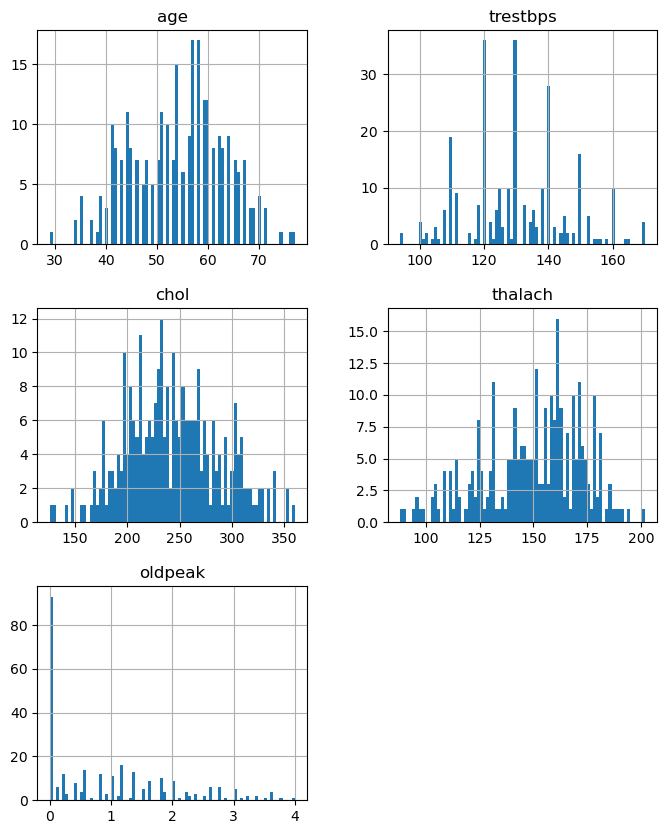

In [1763]:
df3[num_attributes].hist(bins=80, figsize=(8, 10));

In [1764]:
# We can see an accumulation of 'oldpeak' in point zero and
# this can be investigated further.
# In general, we have good gaussian distributions, as expected.

##### <font color='lightblue'> Bivariate Analysis </font>

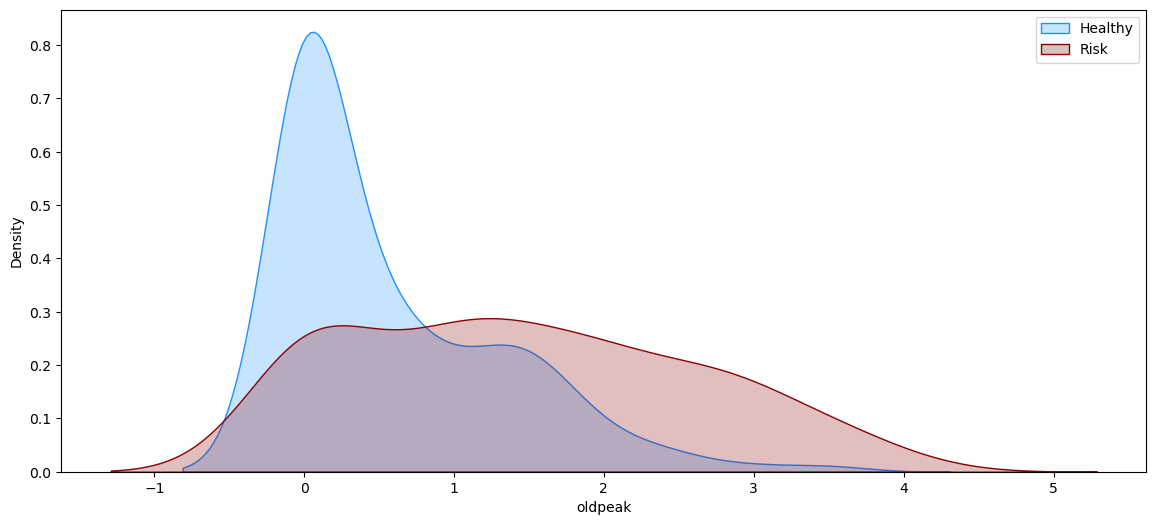

In [1765]:
# 'oldpeak' analysis just to get a hang of it.
# Figure size.
plt.figure(figsize=(14, 6))

# Plot for healthy patients.
sns.kdeplot(df3.loc[df3['num'] == 0, 'oldpeak'], label='Healthy', color='dodgerblue', shade=True)

# Plot for risk patients.
sns.kdeplot(df3.loc[df3['num'] == 1, 'oldpeak'], label='Risk', color='darkred', shade=True)

# Show legend and graph.
plt.legend()
plt.show()

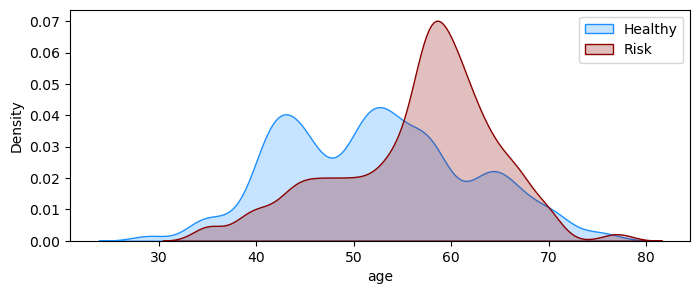

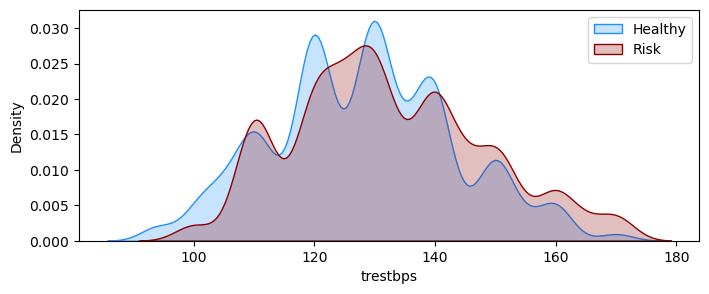

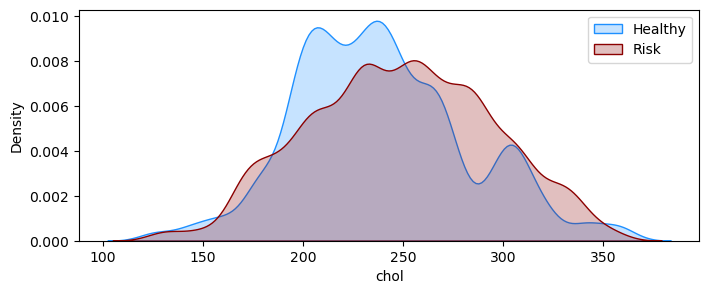

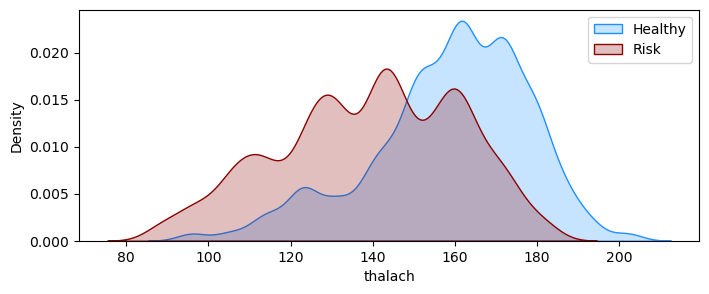

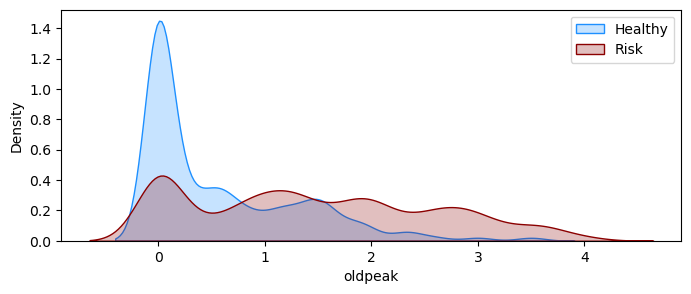

In [1766]:
# We can see that 'oldpeak' serves as a good indicator for heart health.
# From that, we can generalize and see how the other variables behave too.
for att in num_attributes:
    # Figure settings.
    plt.figure(figsize=(8, 3))

    # Plots for healthy and risk patients
    sns.kdeplot(df3.loc[df3['num'] == 0, att], label='Healthy', bw_adjust=0.5, color='dodgerblue', shade=True)
    sns.kdeplot(df3.loc[df3['num'] == 1, att], label='Risk', bw_adjust=0.5, color='darkred', shade=True)

    # Show plots.
    plt.legend()
    plt.show()

In [1767]:
# NUMERICAL ATTRIBUTES
# 1. age - Risk patients tend to be older;
#   * TRUE *

# 2. trestbps - Risk patients are more common to have higher resting
# blood pressure;
#   * TRUE * But the difference between groups is small.

# 3. chol - It's more common to find high serum cholesterol patients
# among the risk group;
#   * TRUE *

# 4. thalach - maximum heart rate achieved higher for risk patients,
# athletes tend to have lower heart rate overall;
#   * FALSE * Looks like healthy people has some extra power.

# 5. oldpeak - ST segment instability are common in patients with heart
# disease.
#   * TRUE * Very significant difference between groups.

#### 3.2.2 Categorical Attributes

##### <font color='lightpink'> Uni and Bivariate Analysis </font>

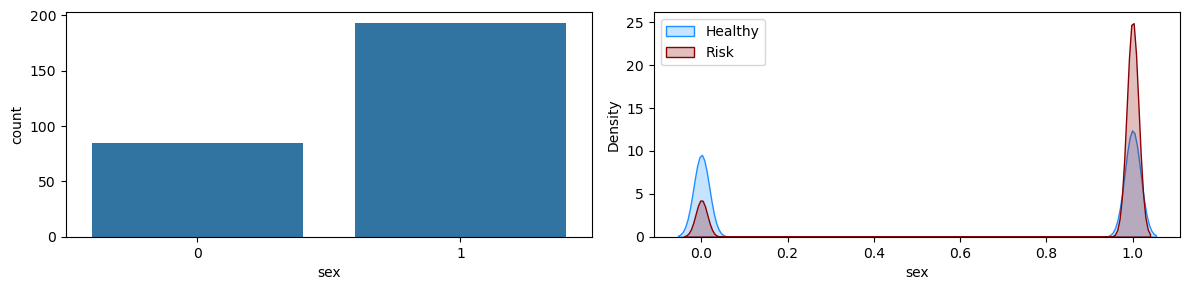

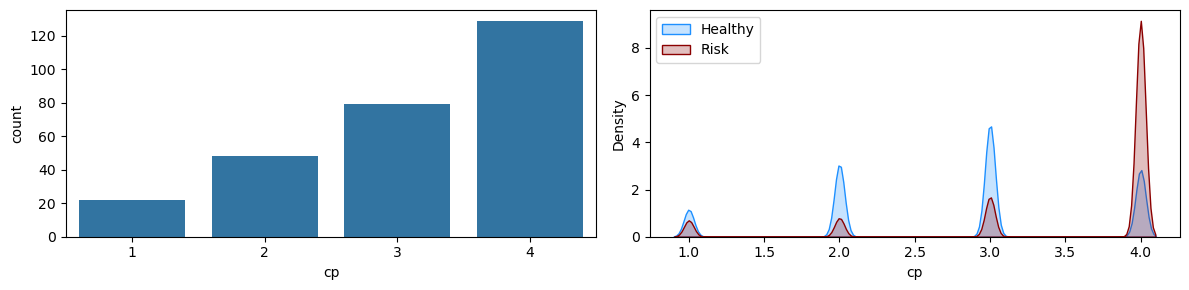

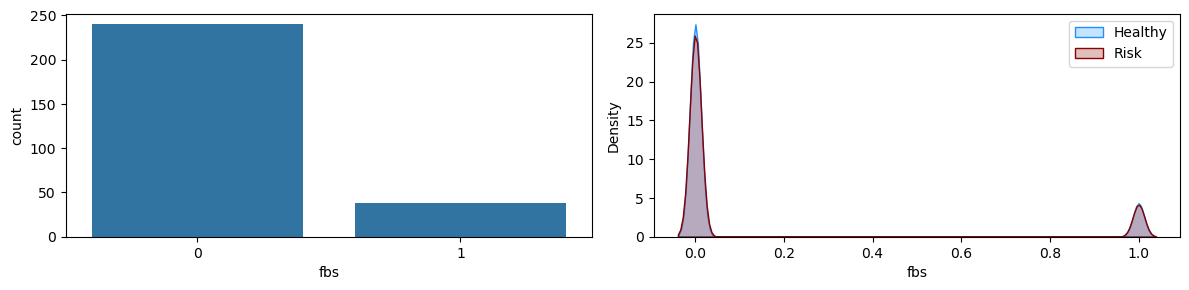

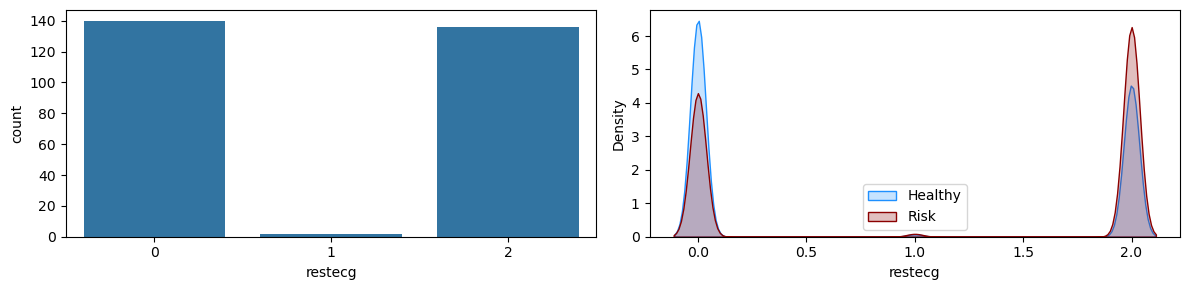

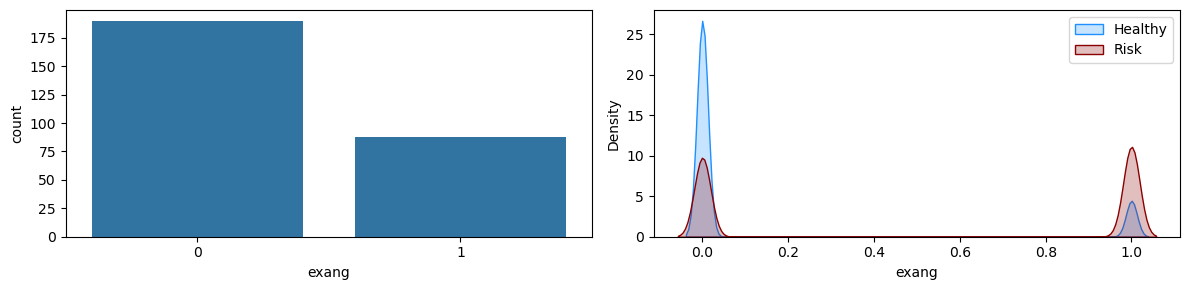

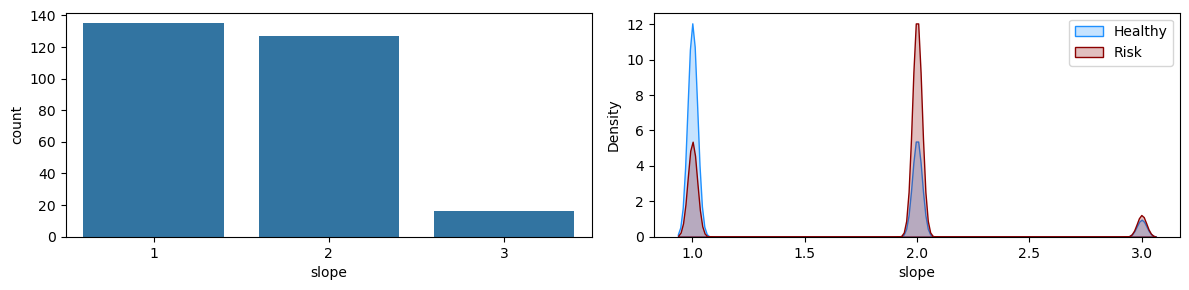

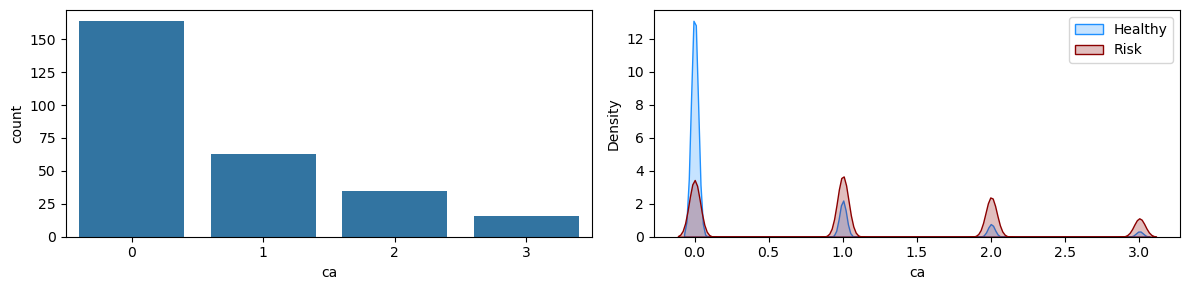

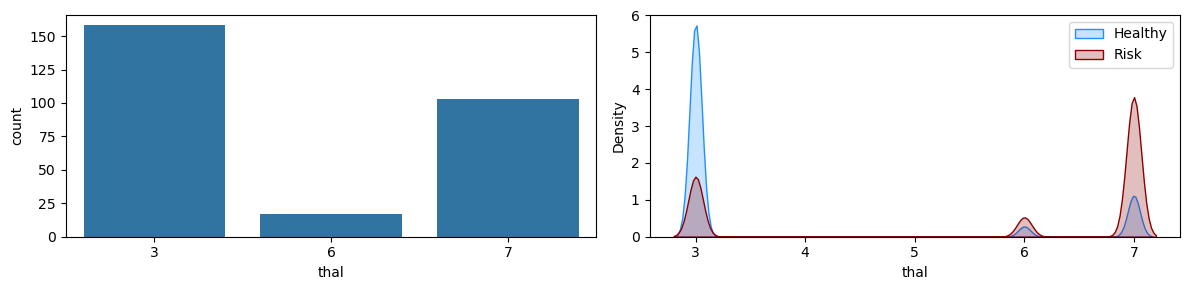

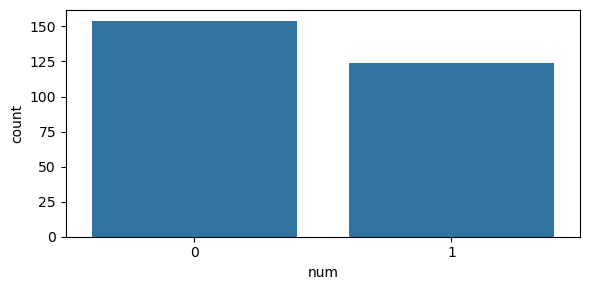

In [1768]:
for att in cat_attributes:
    # Target variable plot.
    if att == 'num':
        fig, axes = plt.subplots(1, 1, figsize=(6, 3))
        sns.countplot(x=att, data=df3)

        # Show plot
        plt.tight_layout()
        plt.show()

        # Go to next att.
        continue

    # Categorical Features plot.
    # Figures settings.
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    # Count of the attribute.
    sns.countplot(x=att, data=df3, ax=axes[0])

    # Comparison to the target variable.
    sns.kdeplot(df3.loc[df3['num'] == 0, att], label='Healthy', color='dodgerblue', shade=True, bw_adjust=0.1, ax=axes[1])
    sns.kdeplot(df3.loc[df3['num'] == 1, att], label='Risk', color='darkred', shade=True, bw_adjust=0.1, ax=axes[1])

    # Show plots
    plt.legend()
    plt.tight_layout()
    plt.show()

In [1769]:
# CATEGORICAL ATTRIBUTES
# 6. sex - Women (0) take more care of themselves and see doctors more 
# often, meaning lower risk of developing diseases in general;
#   * TRUE *

# 7. cp - chest pain (1, 2, 3) may indicate problems around the chest, 
# anginal (1, 2) often indicate a heart disease (value 4 should be more 
# common in healthy patients);
#   * FALSE * eXCUSE ME, WTf? Just found out that ischemia can be 
# * "silent"... Scary.

# 8. fbs - high sugar (1) is usually related to heart diseases;
#   * FALSE * Little to no difference between groups.

# 9. restecg - abnormal (1) and compromised (2) ECG results should be
# more often on risk patients;
#   * TRUE *

# 10. exang - angina by exercising (1) should indicate risk;
#   * TRUE *

# 11. slope - ST slope should be flat (2), most important cause of
# ST segment abnormality is myocardial ischaemia or infarction 
# (source: litfl.com/st-segment-ecg-library/ accessed in 2024-sep-05);
#   * FALSE * Apparently, the expected slope while exercising is 
# * different from rest slope. Up slope is the healthy one.

# 12. ca - I don't know what result we should get, let's assume
# that less color vessels mean higher risk;
#   * FALSE * 0 is healthy, the others indicate risk. Further
# * research let me understand that are multiple types of color-
# * coding, depending on the purpose of the Angiography. We should
# * get better info with the medical team about the procedure.

# 13. thal - normal (3) means lower risk, defects (6, 7) should be 
# more common in risk patients.
#   * TRUE *


# Also, we have a lot of risk patients, almost half of our sample (> 50% diameter narrowing).

### 3.3 Multivariate Analysis

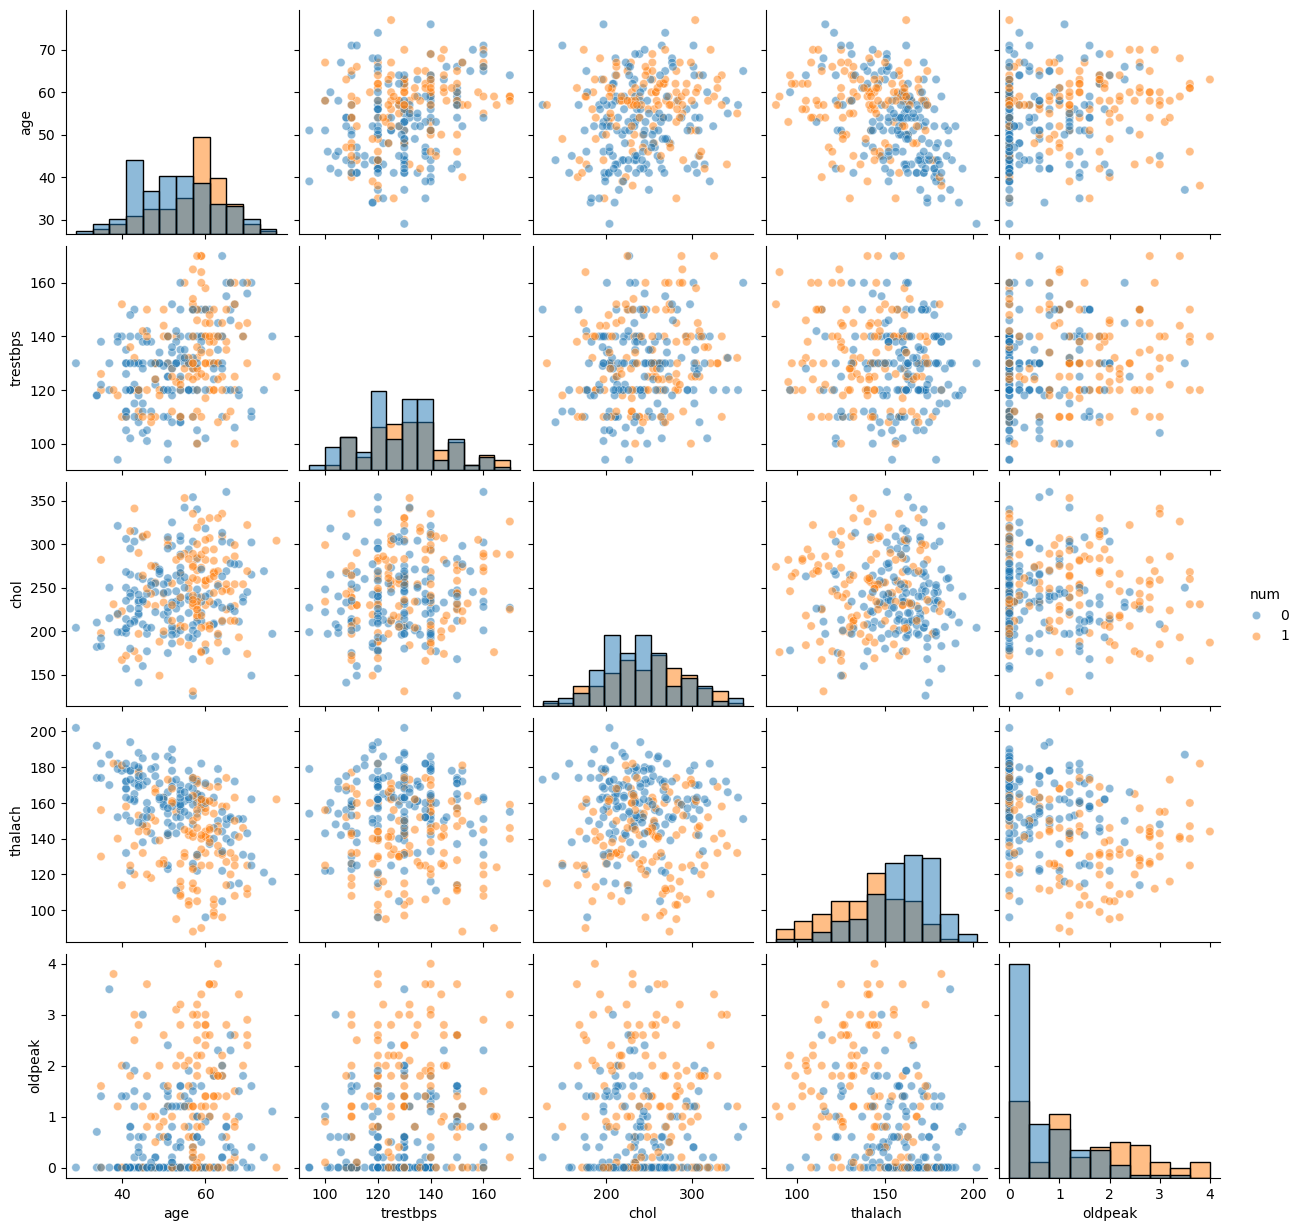

In [1770]:
# Now we can try to find other correlations between variables
# and see how much each one impact the target variable compared
# to one another.
#
# Seaborn pairplot in histograms can give us a good 2-D overview
# of our numerical attributes related to target.
pplot_attributes = num_attributes.copy()
pplot_attributes.append('num')
sns.pairplot(df3[pplot_attributes], hue = 'num', diag_kind='hist', plot_kws={'alpha':0.5});

In [1771]:
# As an 2-dimensional hitplot, being the target variable indicated
# by color. We are looking for diagonal shifts between the two
# color spreads.
#
# Diagonal spreads mean greater correlation betwen two features,
# and diagonal shifts mean they are both greatly affecting the target.
#
# Most diagonal-ish spreads:
# age x thalach, age x trestbps, trestbps x thalach, 
# thalach x oldpeak.
#
# Most evident diagonal shifts:
# age x thalach, age x oldpeak, thalach x oldpeak
#
# So we should give double attention to 'age', 'thalach' and 'oldpeak'.

<Axes: >

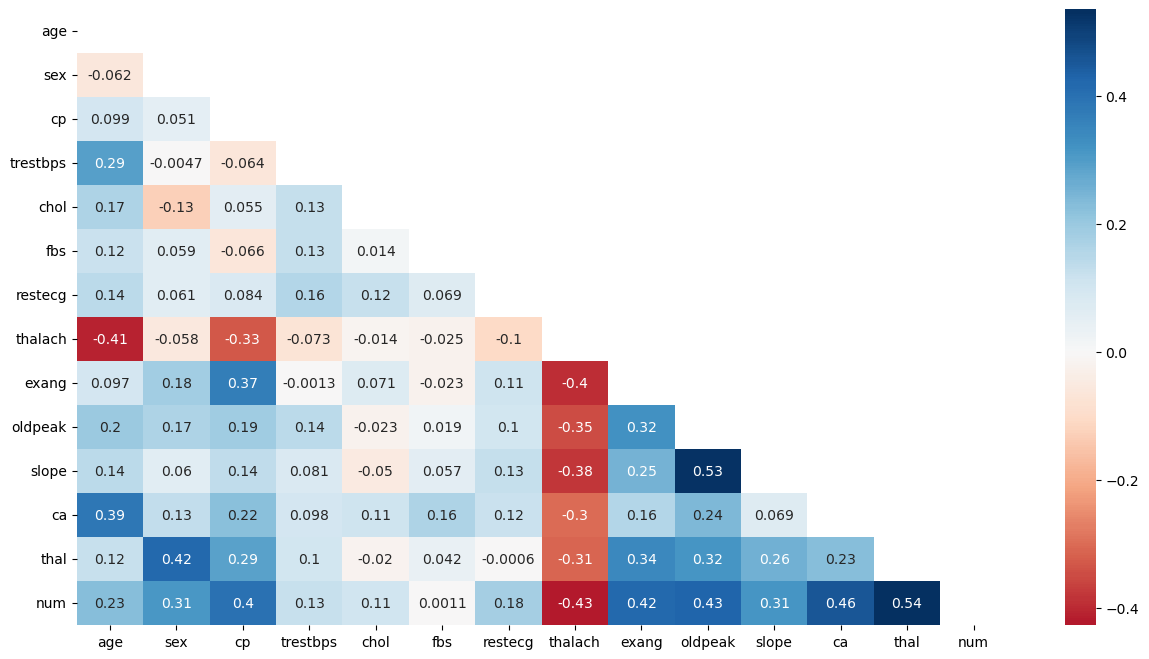

In [1772]:
# Examining a heatmap, we could confirm the assumptions above
# and evaluate how the categorical attributes play along.
#
# Figures layout.
fig,ax = plt.subplots(figsize=(15,8))

# Getting the correlation matrix.
corr = df3.corr()
corr = corr.round(4)

# Taking the upper triangle of the correlation matrix.
matrix = np.triu(corr)

# Using the upper triangle matrix as mask to only show what's left.
sns.heatmap(corr, center=0, cmap='RdBu', annot=True, mask=matrix)

In [1773]:
# Here we can confirm that 'thalach' and 'oldpeak' have
# the greatest influence over 'num', followed by 'age',
# when watching only num_attributes.
#
# For cat_attributes, we can highlight 'cp', 'ca', 'exang'
#  and 'thal', followed by 'sex' and 'slope'.
#
# Another interesting result is 'fbs' showing little to
# no correlation to every other variable, except for
# 'age', 'trestbps' and 'ca'. It may affect our target
# indirectly but we should try taking it off our future
# models to investigate its impact.


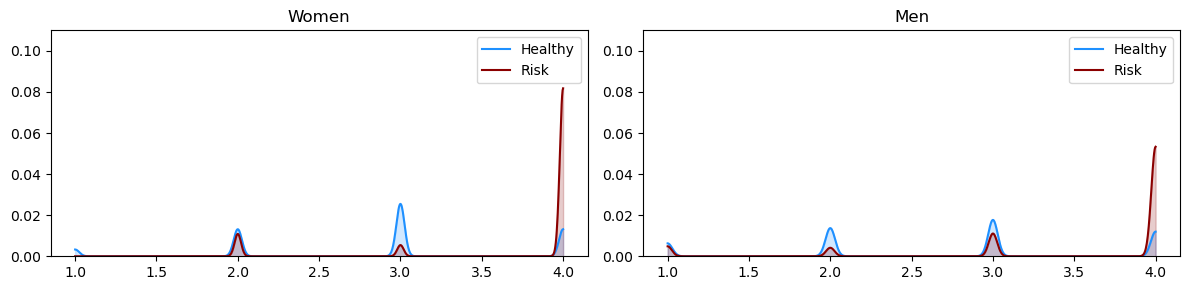

In [1774]:
# Further investigating the case of asymptomatic chest 
# pain, I found good information about how it's sex related
# even though it looks to have no correlation according
# to the heatmap above. 
# Now looking at how it differs from men to women.
#
# Plotting relative distribution of 'cp' for men and women,
# healthy and in risk.
# Figures settings
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

def plot_kde_normalized(ax, data, label, color):
    # Compute KDE
    kde = gaussian_kde(data, bw_method=0.03)
    x = np.linspace(1, 4, 1000)
    y = kde(x)
    
    # Normalize to 100%
    y = y / y.sum()
    
    # Plot
    ax.plot(x, y, label=label, color=color)
    ax.fill_between(x, y, color=color, alpha=0.2)

# Women
plot_kde_normalized(axes[0], df3.loc[(df3['num'] == 0) & (df3['sex'] == 0), 'cp'], label='Healthy', color='dodgerblue')
plot_kde_normalized(axes[0], df3.loc[(df3['num'] == 1) & (df3['sex'] == 0), 'cp'], label='Risk', color='darkred')

# Men
plot_kde_normalized(axes[1], df3.loc[(df3['num'] == 0) & (df3['sex'] == 1), 'cp'], label='Healthy', color='dodgerblue')
plot_kde_normalized(axes[1], df3.loc[(df3['num'] == 1) & (df3['sex'] == 1), 'cp'], label='Risk', color='darkred')


# Adjusting layout, titles and legends
axes[0].set_title('Women')
axes[0].set_ylim(0, 0.11)
axes[1].set_title('Men')
axes[1].set_ylim(0, 0.11)

axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()


In [1775]:
# Typical Angina: Great indicator for men in risk, it's not a symptom in women;
# Atypical Angina: Great indicator for women in risk, less frequent in men;
# Non-Anginal Chest Pain: Great indicator for men, not for women;
# Asymptommatic: Way more common for women.
#
# With further research, I could find that the diagnosis for men and women are 
# quite different. Being chest pain, commonly spread as a must have sympton, 
# being greatly relevant for diagnosing men, but not women.
#
# According to the Hospital Einstein blog (https://vidasaudavel.einstein.br/infarto
# -em-mulheres-conheca-mitos-e-verdades-sobre-ataque-cardiaco/, accessed in 2024-sep
# -06):
# "[...] women describe chest pain as pressure or a tight feeling, and not as an 
# accute pain. Other frequent symptoms in female sex patients are:
# Burning skin; pain in neck, shoulders, face and jaw; difficulty breathing; 
# fatigue; palpitations."
#
# From the National Library of Medicine (https://www.ncbi.nlm.nih.gov/medgen/149267#:
# ~:text=Definition,from%20NCI%5D, accessed in 2024-sep-06), they define Atypical
# Angina as:
# "Angina pectoris which does not have associated classical symptoms of chest pain. 
# Symptoms may include weakness, nausea, or sweating."


In [1776]:
# That show that we can not rely solely on a heatmap
# to determine feature correlation. Specially because 
# the value 4 of 'cp' has huge impact on the distribution.


### 3.4 Feature Engineering

In [1777]:
# Best correlation found until now was between
# symptomns and sex, and I have a plan for it when
# it's time to encode the cat_attributes.

# 4 DATA MODELING

In [1778]:
# Time to prepare our data for the ML algorithms.
df4 = df3.copy()

### 4.1 Data Preprocessing

#### 4.1.1 Scalers

In [1779]:
# As I'm planning to use tree based models, I was not
# going to scale our numerical attributes. But they always 
# work better when doing it for some reason.
# Not much better, but it helps.
#
# MinMaxScaler for old_peak, because this one does not have a good
# bell shape. And StandardScaler for the rest of the num attributes.
cols_minmax = ['oldpeak']
cols_std = num_attributes = [att for att in num_attributes if att != 'oldpeak']

# Scalers
mms = MinMaxScaler()
ss = StandardScaler()

df4[cols_minmax] = mms.fit_transform(df4[cols_minmax])
df4[cols_std] = ss.fit_transform(df4[cols_std])

# Saving scalings to not have parameters all around the place when plugging an API.
pickle.dump( mms, open( 'parameter/cols_minmax.pkl', 'wb' ) )
pickle.dump( ss, open( 'parameter/cols_std.pkl', 'wb' ) )

#### 4.1.2 Encoders

In [1780]:
# Let's check our categorical attributes values.
for att in cat_attributes:
    print('{}, values: {}'.format(att, df3[att].unique()))

sex, values: [1 0]
cp, values: [1 4 3 2]
fbs, values: [1 0]
restecg, values: [2 0 1]
exang, values: [0 1]
slope, values: [3 2 1]
ca, values: [0 3 2 1]
thal, values: [6 3 7]
num, values: [0 1]


In [1781]:
# sex: fine (labeled);
# * cp: It's already label encoded, but I'll reduce the amount of labels;
# fbs: fine (labeled);
# restecg: fine (ordinal);
# exang: fine (labeled);
# slope: fine (ordinal);
# ca: fine (ordinal);
# * thal: encoding reordination;
# num: target, fine.

In [1782]:
# The'cp' values 1 and 3 are almost irrelevant for women.
# On the other hand, they are good indicators of heart 
# disease for men.
#
# Value 2 is way more influent on women then on men.
#
# As a solution, we can separate male from female related 
# symptoms, as they are really dependent on sex. This will
# help the ML algorithms work less.
#
# New Chest Pain 'cp':
# 0 = female related symptoms[former 2]),
# 1 = male related symptoms [former 1 and 3],
# 2 = asymptomatic [former 4].
if 4 in list(df3['cp'].unique()):
    df3['cp'] = df3['cp'].replace(to_replace=[1, 2, 3, 4], value=[1, 0, 1, 2])
else:
    print('Already adjusted.')

# 'thal' values only need a reordination.
if 7 in list(df3['thal'].unique()):
    df3['thal'] = df3['thal'].replace(to_replace=[3, 6, 7], value=[0, 1, 2])
else:
    print('Already adjusted.')

### 4.2 Training-Validation Split

In [1783]:
# Firts, let's define our X, y dataframes.
X = df4.drop(columns=['num'])
y = df4['num']

# Features (X) and target (y) selection.
print('Data shape - X: {}, y: {}'.format(X.shape, y.shape))

Data shape - X: (278, 13), y: (278,)


In [1784]:
# In my planning I was going to write my own frunction for
# this, but why?
# From the scikit-learn documentation, we can use the
# train_test_split helper function to split our data and
# save a replicable state.
#
# Replicable state number 11,
# Test sample of 20%.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

print('Training data sample - X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('Testing data sample - X: {}, y: {}'.format(X_test.shape, y_test.shape))

Training data sample - X: (222, 13), y: (222,)
Testing data sample - X: (56, 13), y: (56,)


### 4.3 Cross-Validation

#### 4.3.1 Decision Tree Classifier

In [1785]:
# The Cross-Validation Helper function can be found in
# the beggining of this jupyter notebook. It's in the
# markdown CODE SUPPORT/Helper Functions, right after 
# the imports. Its name is recall_f1_cv.
#
# Our cross-validation will divide our training data
# in 5 groups, to make it close to the size of our test
# sample.
#
# First we run our baseline DecisionTreeClassifier.
def dt_result_cv():
    model = DecisionTreeClassifier()
    dt_result_cv = recall_f1_cv(x_cv=X_train, y_cv=y_train, kfold=5, 
                                model_name='Decision Tree', model=model, verbose=False)

    return dt_result_cv

dt_result_cv()

,Model Name,Recall Score,F1 Score
0,Decision Tree,0.75,0.73


#### 4.3.2 Random Forest

In [1786]:
# Then our baseline Random Forest.
def rf_result_cv():
    model = RandomForestClassifier()
    rf_result_cv = recall_f1_cv(x_cv=X_train, y_cv=y_train, kfold=5, 
                                model_name='Random Forest', model=model, verbose=False)

    return rf_result_cv

rf_result_cv()

,Model Name,Recall Score,F1 Score
0,Random Forest,0.72,0.78


#### 4.3.3 XGboost

In [1787]:
# And baseline XGBoost
model = XGBClassifier()
xgb_result_cv = recall_f1_cv(x_cv=X_train, y_cv=y_train, kfold=8, 
                             model_name='XGBoost', model=model, verbose=False)

xgb_result_cv

,Model Name,Recall Score,F1 Score
0,XGBoost,0.73,0.77


In [1788]:
# As I was getting always the same result for XGBoost, 
# I printed the classification report to check if the
# error was generalized. And it was.
model = XGBClassifier(
    random_state=None,
    objective='binary:logistic',
    n_estimators=900,
    eta=0.01,
    max_depth=100,
    min_samples_leaf=5,
    min_child_weight=0,
    colsample_bytree= 0.5,
    subsample=0.5
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.83      0.89      0.86        28

    accuracy                           0.86        56
   macro avg       0.86      0.86      0.86        56
weighted avg       0.86      0.86      0.86        56



### 4.4 Choosing Model

In [1789]:
# XGBoost is giving the same result everytime I run it.
# So it's not gonna be used.
#
# Models that we can hypertune: DecisionTree and RandomForest.
possible_models = [dt_result_cv(), rf_result_cv()]

# Let's see how they perform on average for baseline.
for m in possible_models:

    model_result = pd.DataFrame(columns=['Model Name', 'Recall Score', 'F1 Score'])

    for i in range(0, 1000):
        model_result = pd.concat([model_result, m])

    avg_recall = model_result['Recall Score'].astype(float).mean()
    avg_recall = round(avg_recall, 2)
    avg_f1 = model_result['F1 Score'].astype(float).mean()
    avg_f1 = round(avg_f1, 2)

    m_name = m.loc[0, 'Model Name']
    print('Model Name: {}'.format(m_name))
    print('Average Recall: {}\nAverage F1: {}\n'.format(avg_recall, avg_f1))
    
# Running the comparison, we see that both have similar performance
# on Recall, but Random Forest usually wins on F1.
# Then we go with Random Forest.

Model Name: Decision Tree
Average Recall: 0.72
Average F1: 0.72

Model Name: Random Forest
Average Recall: 0.74
Average F1: 0.79



# 5 HYPERPARAMETER FINE TUNING

In [1790]:
# From now on, we are gonna use Random Forest for fine tuning.
df5 = df4.copy()

### 5.1 Grid Searching best Parameters

In [1791]:
# The results of the grid search for those that don't wanna wait.
best_params = {'max_depth': 3, 
               'max_features': None, 
               'min_impurity_decrease': 0.01, 
               'min_samples_leaf': 1, 
               'min_samples_split': 5, 
               'n_estimators': 26}

In [1792]:
# The grid search that got the last cell results.
'''
# Defining model.
rf = RandomForestClassifier()

# Let's define the parameters for our grid search.
param_grid = {
    'n_estimators': range(10, 51),
    'max_depth' : range(2, 11),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_impurity_decrease': [0.1, 0.01]
}

# Setting GridSearchCV up.
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print('Best parameters:')
print(grid_search.best_params_)
'''

"\n# Defining model.\nrf = RandomForestClassifier()\n\n# Let's define the parameters for our grid search.\nparam_grid = {\n    'n_estimators': range(10, 51),\n    'max_depth' : range(2, 11),\n    'max_features': ['sqrt', 'log2', None],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'min_impurity_decrease': [0.1, 0.01]\n}\n\n# Setting GridSearchCV up.\ngrid_search = GridSearchCV(\n    estimator=rf,\n    param_grid=param_grid,\n    scoring='recall',\n    cv=5,\n    n_jobs=-1\n)\n\ngrid_search.fit(X_train, y_train)\nbest_params = grid_search.best_params_\n\nprint('Best parameters:')\nprint(grid_search.best_params_)\n"

In [1793]:
# Tuning models with the Grid Search result.
rf_tuned = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                  max_depth=best_params['max_depth'],
                                  max_features=best_params['max_features'],
                                  random_state=11)

# Train and predict.
rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)

# Chosen score performance.
recall = round(recall_score(y_test, y_pred), 2)
print('Recall Score: {}'.format(recall))

Recall Score: 0.89


### 5.2 Saving Model

In [1794]:
# Saving our trained model to save our time.
'''
pickle.dump( rf_tuned, open('model/heart_disease_tuned_rf.pkl', 'wb') )
'''

"\npickle.dump( rf_tuned, open('model/heart_disease_tuned_rf.pkl', 'wb') )\n"

# 6 EVALUATION AND INTERPRETATION

In [1795]:
df6 = df5.copy()

In [1796]:
# If you didn't clone the heart-disease repository, don't worry.
# You can run this cell and ignore it.
#
# I already saved my trained and tuned model, let's save some time.
# File path (Windows Service for Linux).
model_path = 'model/heart_disease_tuned_rf.pkl'

# Loading model, if it was saved. If not, just run the previous 
# section: 5 HYPERPARAMETER FINE TUNING.
try:
    with open(model_path, 'rb') as file:
        rf_model = pickle.load(file)
        print("Trained model was successfully loaded.")
except Exception as e:
    print(f"Failed to load the model. Error: {e}")

# Running it again.
y_pred = rf_model.predict( X_test )

Trained model was successfully loaded.


### 6.1 Model Performance

In [1797]:
# Show overall performance results.
accuracy = round(accuracy_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)

print('Accuracy Score: {}'.format(accuracy))
print('Precision Score: {}'.format(precision))
print('Recall Score: {}'.format(recall))
print('F1 Score: {}'.format(f1))

Accuracy Score: 0.61
Precision Score: 0.57
Recall Score: 0.93
F1 Score: 0.7


In [1798]:
# In this first cycle, I chose Recall as my main parameter
# and F1 as my secudary one.
#  
# The reason for it was because I believe that medicine 
# should serve the patients, even if it means extra cost.
# That's why recall/sensitivity was chosen, with the intent
# of minimizing False Negatives and leaving less people
# untreated.
#
# But we live in a capitalist world, so healthcare is also
# business. Then F1 comes into scene, bringing some 
# Precision Score to the table, reducing the number of
# False Positives. This means reducing costs with healthy
# patients. 

<Figure size 1000x700 with 0 Axes>

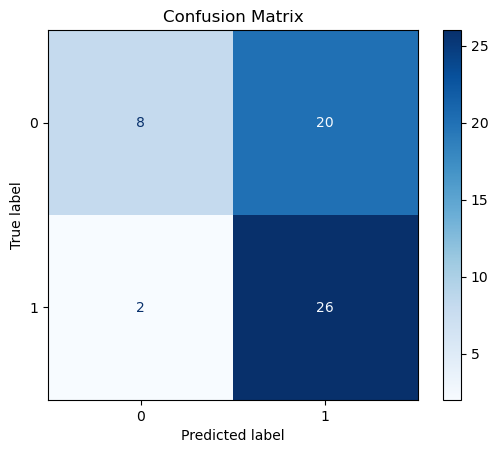

In [1799]:
# Create ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [1800]:
# As expected from our model, it diminishes the amount
# of False Negatives. This means we can treat more risk 
# people properly.
# 
# As a downside, it's not optimized for False Positives.
# This means we'll have an extra cost on those 6 people,
# representing almost 20% of our predictions on risk patients.
# This means not only money but time cost we could be 
# using on treating other people.
#
# That being said, a second cycle on crisp should focus
# on optimizing F1-Score, as it considers both precision
# and recall.

### 6.2 Model Interpretation

#### 6.2.1 Feature Importance

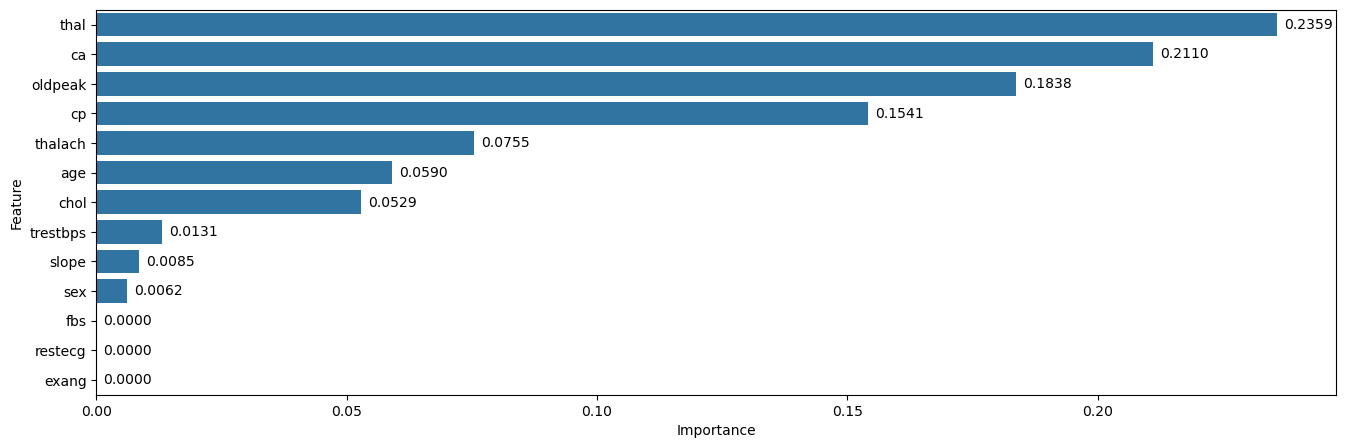

In [1801]:
# Let's check features importance for our model.
# Features used for training.
features = X_train.columns

# Importance for each feature.
importances = rf_model.feature_importances_

# Now let's organize it in a dataframe so we can plot it.
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances})

# Order importances descendingly. 
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Time to vizualize them in a barplot.
plt.figure(figsize=(16, 5))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

# Adding annotations.
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.4f}', (width, p.get_y() + p.get_height() / 2),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=10, color='black')

# Plot feature importances.
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [1802]:
# As shown in the heatmap before, we really should try 
# removing 'fbs' from our model in the next crisp cycle.
# The other ones we should definetly remove are 'restecg'
# and 'exang'. 
# Then we could try re-encoding 'trestbps', 'sex' and 
# 'slope' to see if we can get better results from them.
# 
# Understanding 'ca' a little better can also contribute 
# to future descriptions of our data. It ranks high in 
# our model's features importance. 


#### 6.2.2 SHAP Interpretation

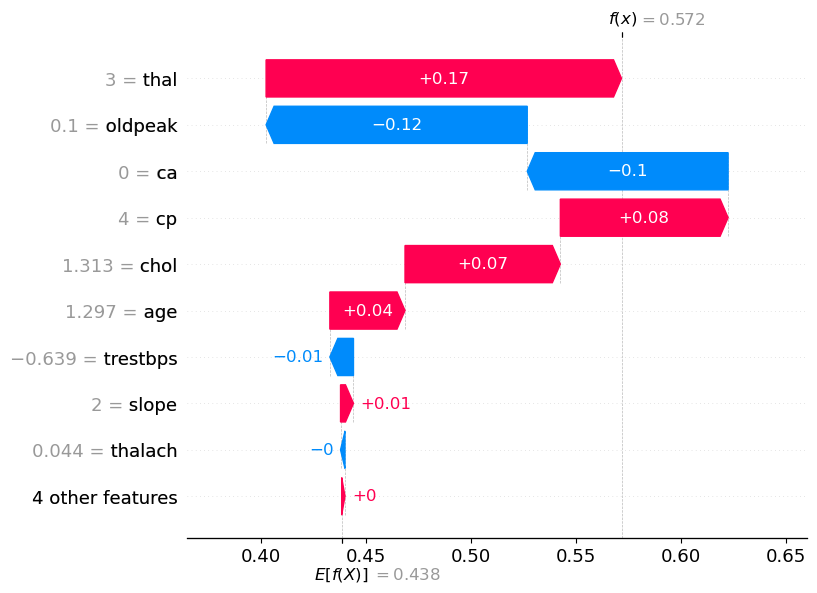

In [1803]:
# TreeExplainer for our Random Forest model.
explainer = shap.TreeExplainer(rf_model)

# SHAP values for our test features.
shap_values = explainer.shap_values(X_test)

# Explanation on how one of the positive classes was chosen.
shap_exp = shap.Explanation(values=shap_values[1],
                            base_values=explainer.expected_value[1], 
                            data=X_test,
                            feature_names=X_test.columns)

# Plotting waterfall graph for our n-th positive instance.
n = 4
shap.waterfall_plot(shap_exp[n])
# shap.plots.force(shap_exp[0:10])

In [1804]:
plt.style.use('default')

# Plotting multiple instances
shap.plots.force(shap_exp[0:10])

In [1805]:
# Now we can see that we really should get rid of 'fbs', 
# 'restecg' and 'exang'. 
#
# And 'trestbps', 'sex' and 'slope' are not that irrelevant
# when watching their impact overall (shap force plot), as 
# the feature importance graph suggested.

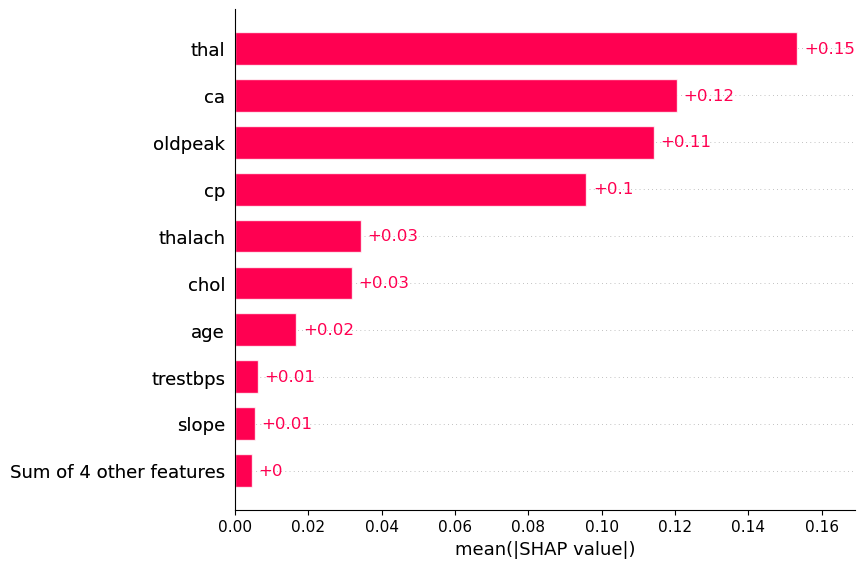

In [1806]:
shap.plots.bar(shap_exp)

In [1807]:
# Seeing the absolute mean SHAP values here, we should
# consider taking 'slope' out too.
#
# Let's try working around 'sex' and 'trestbps'. They 
# are showing enough relevance compared to the low-mid 
# impact features (those around 0.03).

# 7 DEPLOY

In [1808]:
# Next Week.

# NEXT STEPS

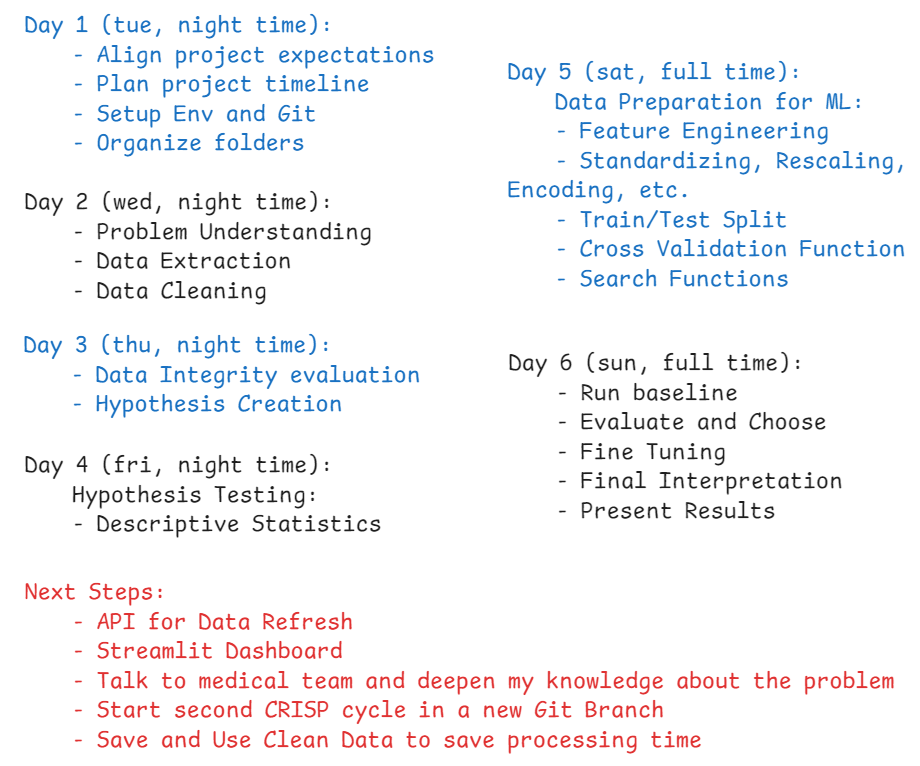

In [1809]:
# Coming back to my week planning.
# Loading timeline img
img = Image.open('img/timeline.png')

# Show
display(img)

In [1810]:
# NEXT STEPS
# ! API + STREAMLIT for real time data response and non-technical user experience !
# This envolves creating class and functions to clean our code.


# * Talk to medical team and deepen my knowledge:
#   - 'ca' - angiography exams are super important for the model but also vague in information;

#   - 'fbs' - showed little correlation to other features in the heatmap, no relevance in 
# feature importance and in SHAP. Let's seek their knowledge about the feature;

#   - 'restecg', 'exang' - also irrelevant in feature importance and SHAP, but showed some 
# results when describing their interaction with the target variable;

#   - 'sex', 'trestbps' - showed low importance results but they were not irrelevant when
# analysing SHAP. Specially when we look only at 'sex' value 0 (women). Maybe we can get
# to better results by preparing these features with more attention;

#   - 'slope' - low SHAP relevance, perhaps we can re-encode and get better results.


# ? Start new CRISP cycle, now with deeper knowledge about the data. Start using a new Git branch.